# ML Process

1. Preprocessing:
  - Remove rows that still have open cases (306 removed out of 98k).
  - Engineer features: hour, day of the week, month of the year
  - Feature selection: check for highly correlated features with correlation matrix
  - Binarize day of the week, neighborhood and type (title/reason) features with get_dummies
  - Aggregate all features upto the hour (creating 11412 rows)
  
     
  - For RF, try without binary data, possibly not aggregated?
  - Standardize with StandardScaler or RobustScaler (to handle outliers better)
  
2. For all models:
  - Split into training/validation/test sets
  - Compare R2 and MRSE
  - Cross-validate to tune parameters, or check consistency of the model

3. LinearRegression:
  - Plot residuals to check linearity principles and see if further transformations are needed

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

#Try this? from sklearn.model_selection import TimeSeriesSplit

pd.set_option('display.max_columns', 100)

In [2]:
# Import data
df_all = pd.read_csv('311_all_features.csv', parse_dates = ['Date', 'closed_date', 'open_day'])
df_all.head(2)

,Date,Time,status,closed_date,days_open,reason,subject,title,object_id,x_coord,y_coord,x_geom,y_geom,opened_year,opened_month,open_day,open_time,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth,geometry,hood
0,2016-01-01,00:10:35,0,2016-01-02 12:03:41,2.0,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,2196,-1.038160e+07,5.613667e+06,-93.259481,44.950087,2016,1,2016-01-01,00:10:35,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.25948128957221 44.95008652484643),Midtown Phillips
1,2016-01-01,07:50:34,0,2016-01-02 09:08:54,2.0,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,29550,-1.038520e+07,5.616158e+06,-93.291802,44.965918,2016,1,2016-01-01,07:50:34,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.29180214798036 44.96591844428954),Lowry Hill


# Feature Engineering and Preprocessing

In [3]:
# Create week_day column
df_all.loc[:, 'week_day'] = df_all.apply (lambda row: row['Date'].weekday() ,axis=1)

# Create hour column
df_all.loc[:, 'hour'] = df_all.apply (lambda row: int(row.loc['Time'][:2]) ,axis=1)

df_all.head(2)

,Date,Time,status,closed_date,days_open,reason,subject,title,object_id,x_coord,y_coord,x_geom,y_geom,opened_year,opened_month,open_day,open_time,closed_year,closed_month,max_temp,min_temp,precipitation,snow,snow_depth,geometry,hood,week_day,hour
0,2016-01-01,00:10:35,0,2016-01-02 12:03:41,2.0,Traffic Control,Vehicles and Commuting,Abandoned Vehicle - Open311,2196,-1.038160e+07,5.613667e+06,-93.259481,44.950087,2016,1,2016-01-01,00:10:35,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.25948128957221 44.95008652484643),Midtown Phillips,4,0
1,2016-01-01,07:50:34,0,2016-01-02 09:08:54,2.0,Traffic Control,Vehicles and Commuting,Parking Violation - Open311,29550,-1.038520e+07,5.616158e+06,-93.291802,44.965918,2016,1,2016-01-01,07:50:34,2016.0,1.0,30,15,0.005,0.005,4.0,POINT (-93.29180214798036 44.96591844428954),Lowry Hill,4,7


In [4]:
df_all.columns

Index(['Date', 'Time', 'status', 'closed_date', 'days_open', 'reason',
       'subject', 'title', 'object_id', 'x_coord', 'y_coord', 'x_geom',
       'y_geom', 'opened_year', 'opened_month', 'open_day', 'open_time',
       'closed_year', 'closed_month', 'max_temp', 'min_temp', 'precipitation',
       'snow', 'snow_depth', 'geometry', 'hood', 'week_day', 'hour'],
      dtype='object')

In [5]:
# Check to see how many cases are not closed. Do we stil have enough data without the open cases?
total = len(df_all)
closed = len(df_all[df_all.status == 0])

print('Number of total cases:', total)
print('Number of closed cases:', closed)
print('% of cases kept: {}'.format(closed/total*100))

Number of total cases: 98670
Number of closed cases: 98364
% of cases kept: 99.68987534204925


In [6]:
# Removing cases that are still open.
df_closed = df_all[df_all.status == 0]

# Check for highly correlated features

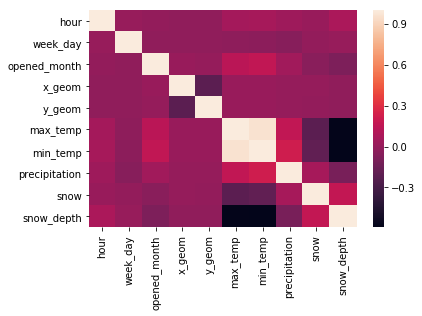

In [7]:
df_numerical = df_closed[['hour', 'week_day', 'opened_month', 'x_geom', 'y_geom', 'max_temp', 'min_temp', 
                     'precipitation', 'snow', 'snow_depth']]
corr = df_numerical.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

# The min_temp and max_temp features are highly correlated. We can remove one or take their mean.
# The min_temp is also somewhat correlated to opened_month and precipitation. We'll remove min_temp.
# Also remove snow_depth becuase it's negatively correlated with temperature.

* The min_temp and max_temp features are highly correlated. We can remove one or take their mean.
* The min_temp is also somewhat correlated to opened_month and precipitation. We'll remove min_temp.
* Also remove snow_depth becuase it's negatively correlated with temperature.

In [8]:
df = df_closed[['Date', 'hour', 'week_day', 'opened_month', 'title', 'x_geom', 'y_geom', 
       'max_temp', 'precipitation', 'snow', 'hood', 'days_open']]
df.head(2)

,Date,hour,week_day,opened_month,title,x_geom,y_geom,max_temp,precipitation,snow,hood,days_open
0,2016-01-01,0,4,1,Abandoned Vehicle - Open311,-93.259481,44.950087,30,0.005,0.005,Midtown Phillips,2.0
1,2016-01-01,7,4,1,Parking Violation - Open311,-93.291802,44.965918,30,0.005,0.005,Lowry Hill,2.0


# Is the target variable normal?

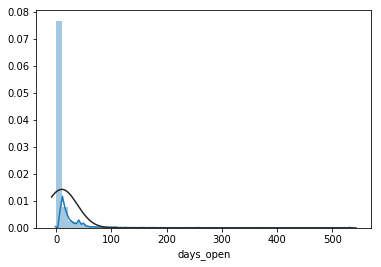

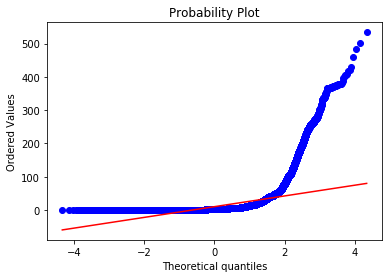

In [9]:
#histogram and normal probability plot
from scipy.stats import norm
sns.distplot(df['days_open'],fit=norm);
fig = plt.figure()
res = stats.probplot(df['days_open'], plot=plt)

From the plots above, we can see it is not normally distributed. From our previous EDA, we know the mean days open is 3 days, visible here as a large peak on the left. There's also a very long tail which stretched past 500 days.

Linear regression is not likely to work well for this data.

In [10]:
df['days_open'].sort_values().head()

90390    0.0
49182    1.0
28849    1.0
61719    1.0
28851    1.0
Name: days_open, dtype: float64

In [11]:
df = df.drop([90390])
df['days_open'].sort_values().head()

49182    1.0
61721    1.0
61719    1.0
28849    1.0
61718    1.0
Name: days_open, dtype: float64

# Predict on title

In [12]:
# Check which titles have the fewest 311 cases. When we make this feature binary,
# one column is typically dropped to avoid redundancy, 
# (since it can be inferred from the other columns). However, the rows will later be
# aggregated by hour. Dropping a column might not necessary.

df.title.value_counts().tail()

Commercial Structure Unsound              7
Bridge Complaint                          7
Water Pollution Complaint                 6
Certificate of Code Compliance Request    3
Bicycle Trail Improvement Request         2
Name: title, dtype: int64

In [13]:
# Create X columns - Title feature by hour

df_titles_hr = df[['Date', 'hour', 'title']]

# transform categorical feature to binary
X_titles_hr = pd.get_dummies(df_titles_hr)

# drop one column to avoid redundancy
X_titles_hr = X_titles_hr.drop('title_Bicycle Trail Improvement Request', axis=1)

# aggregate by day and by HOUR
X_titles_hr = X_titles_hr.groupby(['Date', 'hour']).sum().astype('float64')

# Quick view
print(len(X_titles_hr))
X_titles_hr.head(3)

11412


title_Abandoned Vehicle  title_Abandoned Vehicle - Open311  \
Date       hour                                                               
2016-01-01 0                         0.0                                1.0   
           7                         0.0                                0.0   
           8                         0.0                                0.0   

                 title_Abandoned/Illegally Parked Bicycle  \
Date       hour                                             
2016-01-01 0                                          0.0   
           7                                          0.0   
           8                                          0.0   

                 title_Air Pollution Complaint  \
Date       hour                                  
2016-01-01 0                               0.0   
           7                               0.0   
           8                               0.0   

                 title_Animal Complaint - Livability  \
Date       hour                                        
2016-01-01 0                                     0.0   
           7                                     0.0   
           8                                     0.0   

                 title_Animal Complaint - Public Health  \
Date       hour                                           
2016-01-01 0                                        0.0   
           7                                        0.0   
           8                                        0.0   

                 title_Barricade Pickup / Placement  title_Bicycle Lane Issue  \
Date       hour                                                                 
2016-01-01 0                                    0.0                       0.0   
           7                                    0.0                       0.0   
           8                                    0.0                       0.0   

                 title_Bike Lane Issue - Open311  title_Bridge Complaint  \
Date       hour                                                            
2016-01-01 0                                 0.0                     0.0   
           7                                 0.0                     0.0   
           8                                 0.0                     0.0   

                 title_Campaign Sign Complaint  \
Date       hour                                  
2016-01-01 0                               0.0   
           7                               0.0   
           8                               0.0   

                 title_Certificate of Code Compliance Request  \
Date       hour                                                 
2016-01-01 0                                              0.0   
           7                                              0.0   
           8                                              0.0   

                 title_Certificate of Occupancy Request  title_Chemical Spill  \
Date       hour                                                                 
2016-01-01 0                                        0.0                   0.0   
           7                                        0.0                   0.0   
           8                                        0.0                   0.0   

                 title_Commercial Disability Zone  \
Date       hour                                     
2016-01-01 0                                  0.0   
           7                                  0.0   
           8                                  0.0   

                 title_Commercial Food Safety/Sanitation Complaint  \
Date       hour                                                      
2016-01-01 0                                                   0.0   
           7                                                   0.0   
           8                                                   0.0   

                 title_Commercial Structure Unsound  \
Date       hour                              

In [14]:
# Create y (target variable)

y = df[['Date', 'hour', 'days_open']]

# aggregate by day and by HOUR
y = y.groupby(['Date', 'hour']).mean()

# View
print(len(y))
print(y.shape)
y.head(3)

11412
(11412, 1)


days_open
Date       hour           
2016-01-01 0           2.0
           7           2.0
           8          39.0

In [15]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler(with_mean=False)),
        ('lm', LinearRegression())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_titles_hr, y, test_size = 0.3, random_state=42)

# Fit the pipeline to the training set: knn_scaled
lm_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
lm_unscaled = LinearRegression().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(lm_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(lm_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.08345643553852022
Accuracy without Scaling: 0.08345643553852033


In [16]:
## Linear Regression Function ##

def LinRegEval(X, y):
    '''Returns LinearRegression stats and scatter plot of observed vs predicted values.'''

    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=43)

    lm = LinearRegression()
    # Fit the regressor to the training data
    lm.fit(X_train, y_train)

    # Predict on the train and test data
    predicted_train = lm.predict(X_train)
    predicted_test = lm.predict(X_test)
    test_score = lm.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_test)) 
    spearman = spearmanr(y_test, predicted_test)
    pearson = pearsonr(y_test, predicted_test)

    # Compute and print R^2 and RMSE
    print(f'Test data R-2 score: {test_score:>5.3}')
    print(f'Root Mean Squared Error: {rmse:.4}')
    print(f'Estimated intercept coefficient: {lm.intercept_[0]:.4}')
    print(f'Test data Spearman correlation: {spearman[0]:.3}')
    print(f'Test data Pearson correlation: {pearson[0][0]:.3}')

    # scatter plot between predicted days_open (lr.predict(X)) and actuals
    fig, ax = plt.subplots(figsize=(6, 5))
#    sns.regplot(x=lm.predict(X), y=y, fit_reg = True, scatter_kws={'alpha':0.5, 's':60})
    sns.regplot(x=lm.predict(X), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5, 's':60})
                
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.title("Days Open")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = -cross_val_score(lm, X, y, cv = 5, scoring='neg_mean_squared_error')

    # Print the 5-fold cross-validation scores
    print("Cross-Validation Scores: {}".format(cv_scores, 3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

    # Make cross validated predictions
    predictions = cross_val_predict(lm, X, y, cv=5)
    accuracy = r2_score(y, predictions)
    print ('Cross-Predicted Accuracy: %0.3f' % (accuracy))
    
    plt.scatter(predicted_train, predicted_train - y_train, c='b', s=40, alpha=.5)
    plt.scatter(predicted_test, predicted_test - y_test, c='g', s=40, alpha=.6) 
    plt.hlines(y=0, xmin=-10, xmax=50)
    
    
    

Test data R-2 score: 0.0964
Root Mean Squared Error: 12.25
Estimated intercept coefficient: 8.182
Test data Spearman correlation: 0.471
Test data Pearson correlation: 0.312


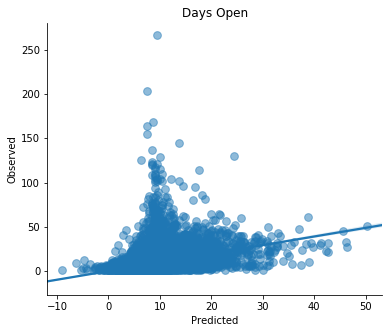

Cross-Validation Scores: [ 85.51934536  72.67771237 255.27358245 184.97811307 115.606685  ]
Accuracy: 142.81 (+/- 136.72)
Cross-Predicted Accuracy: 0.035


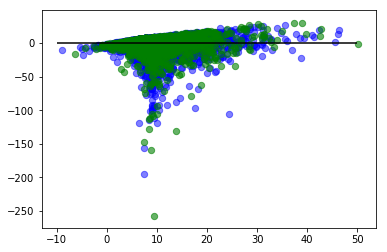

In [17]:
# Apply linear regression to titles data
LinRegEval(X_titles_hr, y)


(11412, 91)
(11412, 20)
Test data R-2 score: 0.0708
Root Mean Squared Error: 12.42
Estimated intercept coefficient: 8.538
Test data Spearman correlation: 0.416
Test data Pearson correlation: 0.267


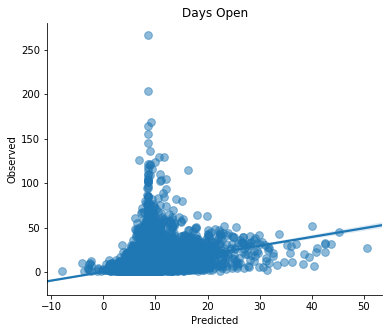

Cross-Validation Scores: [ 86.34783565  71.72558264 259.74380526 189.81537092 113.96776418]
Accuracy: 144.32 (+/- 141.26)
Cross-Predicted Accuracy: 0.025


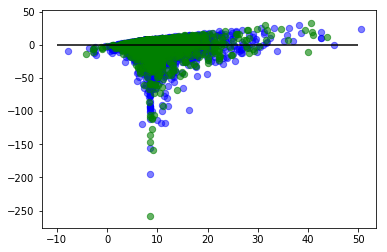

In [18]:
print(X_titles_hr.shape)
(150, 4)
X_titles_hr_new = SelectKBest(mutual_info_regression, k=20).fit_transform(X_titles_hr, y['days_open'])
print(X_titles_hr_new.shape)

# Apply linear regression to titles data
LinRegEval(X_titles_hr_new, y)

# Very slow to run (k=10: R2= 0.04, k=20: R2=0.06)

(11412, 91)
(11412, 50)
Test data R-2 score: 0.0939
Root Mean Squared Error: 12.27
Estimated intercept coefficient: 7.895
Test data Spearman correlation: 0.477
Test data Pearson correlation: 0.307


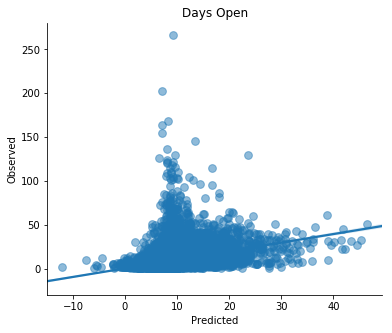

Cross-Validation Scores: [ 85.69560847  72.57765687 255.72510068 184.50706202 115.22442531]
Accuracy: 142.75 (+/- 136.95)
Cross-Predicted Accuracy: 0.035


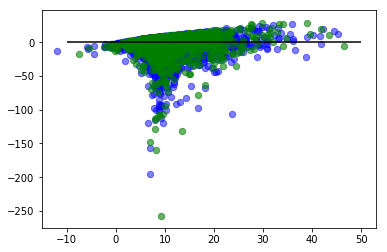

In [19]:
# Feature selection with f_regression

print(X_titles_hr.shape)
(150, 4)
X_titles_hr_new = SelectKBest(f_regression, k=50).fit_transform(X_titles_hr, y['days_open'])
print(X_titles_hr_new.shape)

# Apply linear regression to titles data
LinRegEval(X_titles_hr_new, y)


#### Why does the plot have a peak?

# Outliers
Currently, this model isn't predicting any case will be open for more than 45 days.   

What if we considered outliers to be any case open for longer than 50 days? Or 100 days? How much would the model improve?

In [20]:
## Linear Regression Function ##

def LinRegEval_scaled(X, y):
    '''Returns LinearRegression stats and scatter plot of observed vs predicted values.'''
    
    # Setup LinearRegression
    lm = LinearRegression()

    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)     


    # Fit the lm to the training set
    lm_scaled = lm.fit(X_train_scaled, y_train)


    # Predict on the train and test data
    predicted_train = lm_scaled.predict(X_train)
    predicted_test = lm_scaled.predict(X_test)
    test_score = lm_scaled.score(X_test, y_test)
    rmse = np.sqrt(mean_squared_error(y_test, predicted_test)) 
    spearman = spearmanr(y_test, predicted_test)
    pearson = pearsonr(y_test, predicted_test)

    # Compute and print R^2 and RMSE
    print(f'Test data R-2 score: {test_score:>5.3}')
    print(f'Root Mean Squared Error: {rmse:.4}')
    print(f'Estimated intercept coefficient: {lm.intercept_[0]:.4}')
    print(f'Test data Spearman correlation: {spearman[0]:.3}')
    print(f'Test data Pearson correlation: {pearson[0][0]:.3}')

    # scatter plot between predicted days_open (lr.predict(X)) and actuals
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.regplot(x=lm_scaled.predict(X), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5, 's':60})

    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.title("Days Open")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()
    
    # Compute 5-fold cross-validation scores: cv_scores
    cv_scores = -cross_val_score(lm_scaled, X, y, cv = 5, scoring='neg_mean_squared_error')

    # Print the 5-fold cross-validation scores
    print("Cross-Validation Scores: {}".format(cv_scores, 3))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

    # Make cross validated predictions
    predictions = cross_val_predict(lm_scaled, X, y, cv=5)
    accuracy = r2_score(y, predictions)
    print ('Cross-Predicted Accuracy: %0.3f' % (accuracy))

# Predict on neighborhood

In [21]:
df_hood = df_closed[['Date', 'hour', 'hood']]
X_hood = pd.get_dummies(df_hood)
X_hood = X_hood.groupby(['Date', 'hour']).sum().astype('float64')
X_hood.head(2)


hood_Armatage  hood_Audubon Park  hood_Bancroft  \
Date       hour                                                    
2016-01-01 0               0.0                0.0            0.0   
           7               0.0                0.0            0.0   

                 hood_Beltrami  hood_Bottineau  hood_Bryant  hood_Bryn - Mawr  \
Date       hour                                                                 
2016-01-01 0               0.0             0.0          0.0               0.0   
           7               0.0             0.0          0.0               0.0   

                 hood_CARAG  hood_Camden Industrial  \
Date       hour                                       
2016-01-01 0            0.0                     0.0   
           7            0.0                     0.0   

                 hood_Cedar - Isles - Dean  hood_Cedar Riverside  \
Date       hour                                                    
2016-01-01 0                           0.0                   0.0   
           7                           0.0                   0.0   

                 hood_Central  hood_Cleveland  hood_Columbia Park  hood_Como  \
Date       hour                                                                
2016-01-01 0              0.0             0.0                 0.0        0.0   
           7              0.0             0.0                 0.0        0.0   

                 hood_Cooper  hood_Corcoran  hood_Diamond Lake  \
Date       hour                                                  
2016-01-01 0             0.0            0.0                0.0   
           7             0.0            0.0                0.0   

                 hood_Downtown East  hood_Downtown West  hood_ECCO  \
Date       hour                                                      
2016-01-01 0                    0.0                 0.0        0.0   
           7                    0.0                 0.0        0.0   

                 hood_East Harriet  hood_East Isles  hood_East Phillips  \
Date       hour                                                           
2016-01-01 0                   0.0              0.0                 0.0   
           7                   0.0              0.0                 0.0   

                 hood_Elliot Park  hood_Ericsson  hood_Field  hood_Folwell  \
Date       hour                                                              
2016-01-01 0                  0.0            0.0         0.0           0.0   
           7                  0.0            0.0         0.0           0.0   

                 hood_Fulton  hood_Hale  hood_Harrison  hood_Hawthorne  \
Date       hour                                                          
2016-01-01 0             0.0        0.0            0.0             0.0   
           7             0.0        0.0            0.0             0.0   

                 hood_Hiawatha  hood_Holland  hood_Howe  \
Date       hour                                           
2016-01-01 0               0.0           0.0        0.0   
           7               0.0           0.0        0.0   

                 hood_Humboldt Industrial Area  hood_Jordan  hood_Keewaydin  \
Date       hour                                                               
2016-01-01 0                               0.0          0.0             0.0   
           7                               0.0          0.0             0.0   

                 hood_Kenny  hood_Kenwood  hood_King Field  \
Date       hour                                              
2016-01-01 0            0.0           0.0              0.0   
           7            0.0           0.0              0.0   

                 hood_Lind - Bohanon  hood_Linden Hills  hood_Logan Park  \
Date       hour                                                            
2016-01-01 0                     0.0                0.0              0.0   
           7                     0.0                0.0              0.0   

                 hood_Longfellow  hood_

Test data R-2 score: 0.00894
Root Mean Squared Error: 12.83
Estimated intercept coefficient: 7.123
Test data Spearman correlation: 0.307
Test data Pearson correlation: 0.108


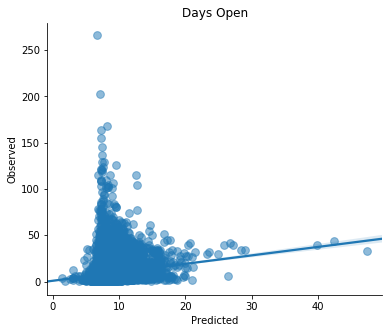

Cross-Validation Scores: [ 87.34255173  71.20140904 267.34924605 205.57703707 125.31819601]
Accuracy: 151.36 (+/- 148.58)
Cross-Predicted Accuracy: -0.023


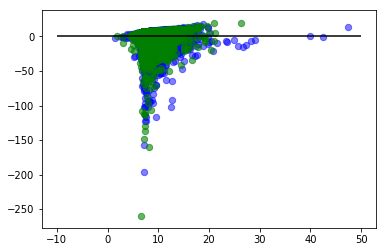

In [22]:
# Apply linear regression to neighborhood data
LinRegEval(X_hood, y)

# Predict on more features

In [23]:
df_nums = df_closed[['Date', 'hour', 'week_day', 'opened_month', 'x_geom', 'y_geom', 'max_temp', 
                     'precipitation']]
X_nums_hr = df_nums.groupby(['Date', 'hour']).mean().astype('float64')

#.agg({'x_geom':'mode', 'y_geom':'mode', 'max_temp':'mean', 'min_temp':'mean', 
#    'precipitation':'mean', 'snow_depth':'mean'})

X_nums_hr.head(2)

week_day  opened_month     x_geom     y_geom  max_temp  \
Date       hour                                                           
2016-01-01 0          4.0           1.0 -93.259481  44.950087      30.0   
           7          4.0           1.0 -93.291802  44.965918      30.0   

                 precipitation  
Date       hour                 
2016-01-01 0             0.005  
           7             0.005

In [24]:
#dummy_cols = ['reason', 'hood']
#train = pd.get_dummies(df, columns = dummy_cols)

In [25]:
# Create df with all numerical features and titles

X_all = pd.concat([X_titles_hr, X_nums_hr], axis=1, join='outer')

# Use the hour column as a feature
X_all = X_all.reset_index(level=['hour'])
X_all.head(2)

,hour,title_Abandoned Vehicle,title_Abandoned Vehicle - Open311,title_Abandoned/Illegally Parked Bicycle,title_Air Pollution Complaint,title_Animal Complaint - Livability,title_Animal Complaint - Public Health,title_Barricade Pickup / Placement,title_Bicycle Lane Issue,title_Bike Lane Issue - Open311,title_Bridge Complaint,title_Campaign Sign Complaint,title_Certificate of Code Compliance Request,title_Certificate of Occupancy Request,title_Chemical Spill,title_Commercial Disability Zone,title_Commercial Food Safety/Sanitation Complaint,title_Commercial Structure Unsound,title_Commercial/Mixed Conditions Complaint,title_Debris in the Street or Alley,title_Emergency Pollution Complaint,title_Exterior Nuisance - Self Service,title_Exterior Nuisance Complaint,title_Fence or Guardrail Maintenance,title_Fire Rig Visit Request,title_Full TISH Report Request,title_General Street Complaint,title_Graffiti - Open311,title_Graffiti complaint / reporting,title_Grass & Weed Complaint,title_Hoarding,title_Homeless Encampment,title_Hydrant Issue,title_Illegal Dumping Complaint,title_Inoperable Vehicle Complaint,title_K9 Appearance Request,title_Land Pollution Complaint,title_Licensing Complaint,title_Neighborhood Parking Information,title_Noise Pollution Complaint,title_Parking Meter - Open311,title_Parking Meter Problem,title_Parking Violation - Open311,title_Parking Violation Complaint,title_Police Mounted Patrol Request,title_Pothole,title_Pothole - Open311,title_RHOD Conditions Complaint,title_RHOD Exterior Nuisance Complaint,title_Repair Notice Question,title_Residential Disability Zone,title_Sewer Issues,title_Sidewalk Obstruction Complaint,title_Sidewalk Snow & Ice Complaint,title_Sidewalk Snow Ice - Open311,title_Sidewalk Snow and Ice - SS,title_Sidewalk Structural - Open311,title_Sidewalk Structural Complaint,title_Sign Complaint,title_Snow & Ice Complaint,title_Snow - Illegal Dumping,title_Solid Waste Overflow Litter,title_Solid Waste Overflowing Litter - Open311,title_Special Sweep,title_Speed Hump Request,title_Speed Wagon,title_Sport Equip in Street,title_Street Light - New,title_Street Light Outage,title_Street Light Outage - Open311,title_Street Light Trouble,title_Street Light Trouble - Open311,title_Street Light Wreck - Open311,title_Street Light Wreck/Damage,title_Streets Snow & Ice - Open311,title_Traffic Sign - New,title_Traffic Sign - Removal,title_Traffic Sign - Repair,title_Traffic Sign Repair - Open311,title_Traffic Signal - New/Modification,title_Traffic Signal Timing - Open311,title_Traffic Signal Timing Issue,title_Traffic Signal Trouble,title_Traffic Signal Trouble - Open311,title_Trees Down,title_Unpermitted Work,title_Unpermitted Work - Self Service,title_Urgent Pollution Complaint,title_Vacant Building / Open to Trespass,title_Vacant Building / Open to Trespass Boarded,title_Water Main Break,title_Water Pollution Complaint,week_day,opened_month,x_geom,y_geom,max_temp,precipitation
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-93.259481,44.950087,30.0,0.005
2016-01-01,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,-93.291802,44.965918,30.0,0.005


Test data R-2 score: 0.105
Root Mean Squared Error: 12.2
Estimated intercept coefficient: -857.5
Test data Spearman correlation: 0.447
Test data Pearson correlation: 0.324


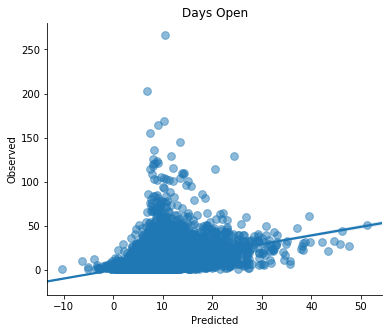

Cross-Validation Scores: [ 88.50378432  71.58773833 253.25418377 188.589271   119.19693969]
Accuracy: 144.23 (+/- 135.24)
Cross-Predicted Accuracy: 0.025


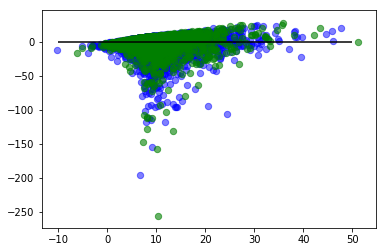

In [26]:
# Apply linear regression to all features
LinRegEval(X_all, y)

Test data R-2 score: 0.102
Root Mean Squared Error: 12.21
Estimated intercept coefficient: -580.9
Test data Spearman correlation: 0.448
Test data Pearson correlation: 0.32


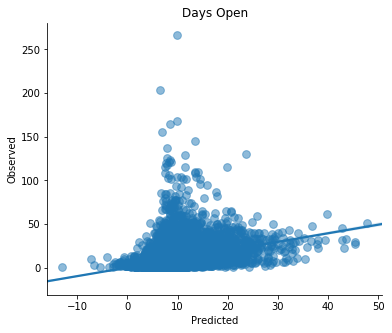

Cross-Validation Scores: [ 89.28366489  71.63184778 253.22310407 188.50716683 118.18411707]
Accuracy: 144.17 (+/- 135.08)
Cross-Predicted Accuracy: 0.026


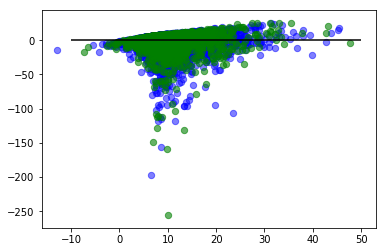

In [27]:
# Select best 30 features
X_all_hr_new = SelectKBest(f_regression, k=60).fit_transform(X_all, y['days_open'])

# Apply linear regression to all features
LinRegEval(X_all_hr_new, y)

In [28]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size = .3, random_state=42)

# Create the regressor: lm
lm = LinearRegression()

# Fit the regressor to the training data
lm.fit(X_train, y_train)
#lm.coef_
# The coefficients
feature_coef = pd.DataFrame({'features': X_all.columns, 
                             'estimatedCoefficients': lm.coef_[0]})[[
                             'features', 'estimatedCoefficients']]

print(feature_coef.sort_values('estimatedCoefficients').head())
print(feature_coef.sort_values('estimatedCoefficients').tail())

                                  features  estimatedCoefficients
10                  title_Bridge Complaint              -5.948928
13  title_Certificate of Occupancy Request              -4.894811
41             title_Parking Meter Problem              -4.631488
25          title_Full TISH Report Request              -3.521746
94                                  x_geom              -3.018208
                                 features  estimatedCoefficients
44    title_Police Mounted Patrol Request               8.060550
30                         title_Hoarding               8.273602
95                                 y_geom               9.040406
67               title_Street Light - New              10.040160
86  title_Unpermitted Work - Self Service              10.484134


The titles with a lot of outliers seem to be the most influential features.

# Ridge Regression

In [29]:
def RidgeEval(X, y):
    '''Splits data into train, validation and test sets. Cross validates alpha values for Ridge Regression.'''
    
    # Create training, validationg and test sets
    # intermediate/test split (gives us test set)
    X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, y,  
                                                                  shuffle=True,
                                                                  test_size=0.2, 
                                                                  random_state=14)

    # train/validation split (gives us train and validation sets)
    X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate,
                                                                y_intermediate,
                                                                shuffle=False,
                                                                test_size=0.25,
                                                                random_state=42)
    # delete intermediate variables
    del X_intermediate, y_intermediate

    # print proportions
    print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y),2),
                                                       round(len(y_validation)/len(y),2),
                                                       round(len(y_test)/len(y),2)))
    alphas = [0.01, 0.1, 1, 10, 100, 1000]
    print('All errors are RMSE')
    print('-'*76)
    for alpha in alphas:
        # instantiate and fit model
        ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=99)
        ridge.fit(X_train, y_train)
        # calculate errors
        new_train_error = mean_squared_error(y_train, ridge.predict(X_train))
        new_validation_error = mean_squared_error(y_validation, ridge.predict(X_validation))
        new_test_error = mean_squared_error(y_test, ridge.predict(X_test))
        # print errors as report
        print('alpha: {:7} | train error: {:5} | val error: {:6} | test error: {}'.
              format(alpha,
                     round(new_train_error,3),
                     round(new_validation_error,3),
                     round(new_test_error,3)))


In [30]:
RidgeEval(X_all, y)

train: 0.6% | validation: 0.2% | test 0.2%
All errors are RMSE
----------------------------------------------------------------------------
alpha:    0.01 | train error: 128.889 | val error: 129.298 | test error: 135.214
alpha:     0.1 | train error: 128.89 | val error: 129.276 | test error: 135.188
alpha:       1 | train error: 128.907 | val error: 129.122 | test error: 135.021
alpha:      10 | train error: 129.138 | val error: 128.784 | test error: 134.557
alpha:     100 | train error: 130.579 | val error: 129.167 | test error: 134.497
alpha:    1000 | train error: 133.773 | val error: 131.134 | test error: 136.486


In [31]:
RidgeEval(X_titles_hr, y)

train: 0.6% | validation: 0.2% | test 0.2%
All errors are RMSE
----------------------------------------------------------------------------
alpha:    0.01 | train error: 130.264 | val error: 130.727 | test error: 135.85
alpha:     0.1 | train error: 130.264 | val error: 130.722 | test error: 135.829
alpha:       1 | train error: 130.269 | val error: 130.68 | test error: 135.674
alpha:      10 | train error: 130.407 | val error: 130.522 | test error: 135.102
alpha:     100 | train error: 131.799 | val error: 130.971 | test error: 134.943
alpha:    1000 | train error: 135.158 | val error: 133.124 | test error: 137.058


Test data R-2 score: 0.0982
Test data Spearman correlation: 0.438
Test data Pearson correlation: 0.315


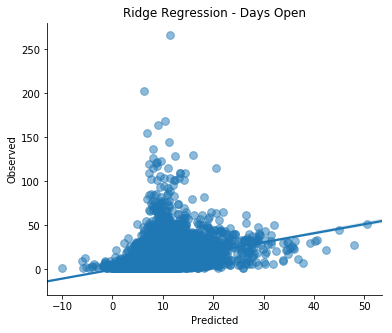

In [33]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y['days_open'], test_size = .3, random_state=42)

# Fit model to training data
ridge = Ridge(alpha=100, fit_intercept=True, random_state=44)
ridge.fit(X_train, y_train)

# Predict and view stats
predicted_train = ridge.predict(X_train)
predicted_test = ridge.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

# scatter plot between predicted days_open and actuals
fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(x=ridge.predict(X_all), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5, 's':60})

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("Ridge Regression - Days Open")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Random Forest Regressor

Out-of-bag R-2 score estimate: 0.109
Test data R-2 score: 0.124
Test data Spearman correlation: 0.581
Test data Pearson correlation: 0.389


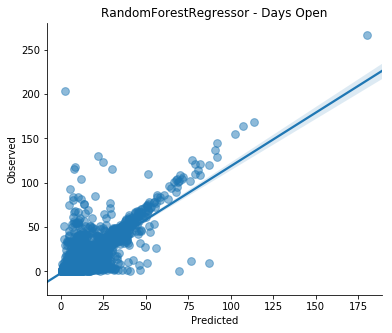

In [34]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_all, y['days_open'], test_size = .3, random_state=42)

# Fit RandomForestRegressor (rfr) model to training data
#rf = rfr(n_estimators=500, oob_score=True, random_state=0)
rf = rfr(n_estimators=500, oob_score=True, random_state=0)
rf.fit(X_train, y_train)

# Predict and view stats
predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')

# scatter plot between predicted days_open and actuals
fig, ax = plt.subplots(figsize=(6, 5))
sns.regplot(x=rf.predict(X_all), y=y['days_open'], fit_reg = True, scatter_kws={'alpha':0.5, 's':60})

plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("RandomForestRegressor - Days Open")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Removing outliers

In [35]:
# Remove cases that have been open for more than 3 months (90 days).

df_no_outliers = df[df.days_open <= 90]